### Check and plot Icecube follow up data


In [13]:
# Load urllib and Beautiful Soup to grab the public GCN alert list.
from urllib.request import urlopen
from bs4 import BeautifulSoup

from astropy.table import Table, unique, vstack
from astropy.time import Time

import os
from glob import glob
import sys

from astropy.table import Table, vstack, join

sys.path.append('/global/homes/p/palmese/desi/timedomain/desitrip/py/') #Note:change this path as needed!
sys.path.append('/global/homes/p/palmese/desi/timedomain/timedomain/')

from desispec.io import read_spectra, write_spectra
from desispec.spectra import Spectra
from desispec.coaddition import coadd_cameras
from desitarget.sv1.sv1_targetmask import bgs_mask as bgs_mask_sv1
from desitarget.sv2.sv2_targetmask import bgs_mask as bgs_mask_sv2
from desitarget.sv3.sv3_targetmask import bgs_mask as bgs_mask_sv3

from desitrip.preproc import rebin_flux, rescale_flux
from desitrip.deltamag import delta_mag

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

from desitarget.io import read_targets_in_hp, read_targets_in_box, read_targets_in_cap, check_hp_target_dir
from desitarget.targetmask import desi_mask, bgs_mask

import healpy as hp
mpl.rc('font', size=14)

In [5]:
def get_amon_icecube_astrotrack_alerts(url=None):
    """Get IceCube alerts from the GCN AMON channel (IceCube astrotrack).
    This corresponds to single neutrino tracks in the detector between
    roughly 100 TeV and 10 PeV, and includes events from the EHE and HESE
    channels.
    
    Parameters
    ----------
    url : str
        URL of GCN alert webpage.
        
    Returns
    -------
    tab : astropy.table.Table
        Table of alert data.
    """
    if url is None:
        url = 'https://gcn.gsfc.nasa.gov/amon_icecube_gold_bronze_events.html'
        
    # Parse the GCN/AMON notice page.
    html = urlopen('https://gcn.gsfc.nasa.gov/amon_icecube_gold_bronze_events.html')
    soup = BeautifulSoup(html.read())
    events = soup.table.find_all('tr')
    
    # Accumulate event data.
    evtid = []
    run = []
    evt = []
    rev = []
    dtm = []
    noticetype = []
    ra = []
    dec = []
    err90 = []
    err50 = []
    energy = []
    signalness = []
    far = []
    comments = []

    for event in events[2:]:
        data = event.find_all('td')
        _id, _rev, _date, _time, _type, _ra, _dec, _err90, _err50, _energy, _sig, _far, _cmt = [_.string.strip() for _ in data]
        _run, _evt = [int(_) for _ in _id.split('_')]
        evtid.append(_id)
        run.append(_run)
        evt.append(_evt)
        rev.append(int(_rev))

        _dtm = '20{}-{}-{}T{}0'.format(*_date.split('/'), _time)
        dtm.append(_dtm)

        noticetype.append(_type)
        ra.append(float(_ra))
        dec.append(float(_dec))
        err50.append(float(_err50) / 60.)
        err90.append(float(_err90) / 60.)
        energy.append(float(_energy))
        signalness.append(float(_sig))
        far.append(float(_far))
        comments.append(_cmt)
    
    # Push data into an astropy table for later access.
    tab = Table()
    tab['EVENTID'] = evtid
    tab['RUNID'] = run
    tab['EVENT'] = evt
    tab['REVISION'] = rev
    tab['TIME'] = dtm #Time(dtm, format='isot')
    tab['NOTICETYPE'] = noticetype
    tab['RA'] = ra
    tab['RA'].unit = 'degree'
    tab['DEC'] = dec
    tab['DEC'].unit = 'degree'
    tab['ERR50'] = err50
    tab['ERR50'].unit = 'degree'
    tab['ERR90'] = err90
    tab['ERR90'].unit = 'degree'
    tab['ENERGY'] = energy
    tab['ENERGY'].unit = 'TeV'
    tab['SIGNALNESS'] = signalness
    tab['FAR'] = far
    tab['COMMENTS'] = comments
    
    return tab

In [6]:
tab = get_amon_icecube_astrotrack_alerts()


nside = 1024

event = tab[tab['EVENTID']=='135736_30987826']
run_c = event['RUNID'][0]
evt_c = event['EVENT'][0]
ra_c = event['RA'][0]
dec_c = event['DEC'][0]
date_c = event['TIME'][0]
vec_c = hp.ang2vec(ra_c, dec_c, lonlat=True)
err50_c = event['ERR50'].to('radian').value[0]
err90_c = event['ERR90'].to('radian').value[0]

pixs90 = hp.query_disc(nside, vec=vec_c, radius=err90_c, nest=True)

### Look at DESITRIP outputs

In [5]:
cand_spec = 'transient_candidate_spectra_20210923_23005.fits'


#zbest = Table.read(cand_spec, 'redshifts')
    
spectra = read_spectra(cand_spec)


INFO:spectra.py:282:read_spectra: iotime 0.172 sec to read transient_candidate_spectra_20210923_23005.fits at 2021-09-24T21:56:28.304191


In [6]:
ra,dec=spectra.fibermap['TARGET_RA'], spectra.fibermap['TARGET_DEC']
hpixs=[]
for k in range(ra.shape[0]):
    hpixs.append(hp.ang2pix(nside,ra[k],dec[k],nest=True, lonlat=True))

In [7]:
hpixs=np.array(hpixs)

idx=[]
for pix90 in pixs90:
    thisidx = np.where(hpixs==pix90)
    if thisidx[0].shape[0]>0:
        idx.append(thisidx[0][0])

In [33]:
import sys
sys.path.append('/global/homes/p/palmese/desi/timedomain/desitrip/py') 
sys.path.append('/global/homes/p/palmese/desi/timedomain/timedomain/')
from scipy.ndimage import gaussian_filter1d
from desispec.resolution import Resolution
from desispec.interpolation import resample_flux
from desitrip.preproc import rebin_flux, rescale_flux
import redrock.templates

templates = dict()
for filename in redrock.templates.find_templates():
    t = redrock.templates.Template(filename)
    templates[(t.template_type, t.sub_type)] = t

DEBUG: Read templates from /global/common/software/desi/cori/desiconda/20190804-1.3.0-spec/code/redrock-templates/master
DEBUG: Using default redshift range -0.0050-1.6997 for rrtemplate-galaxy.fits
DEBUG: Using default redshift range 0.0500-5.9934 for rrtemplate-qso.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-A.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-B.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-CV.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-F.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-G.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-K.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-M.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-WD.fits


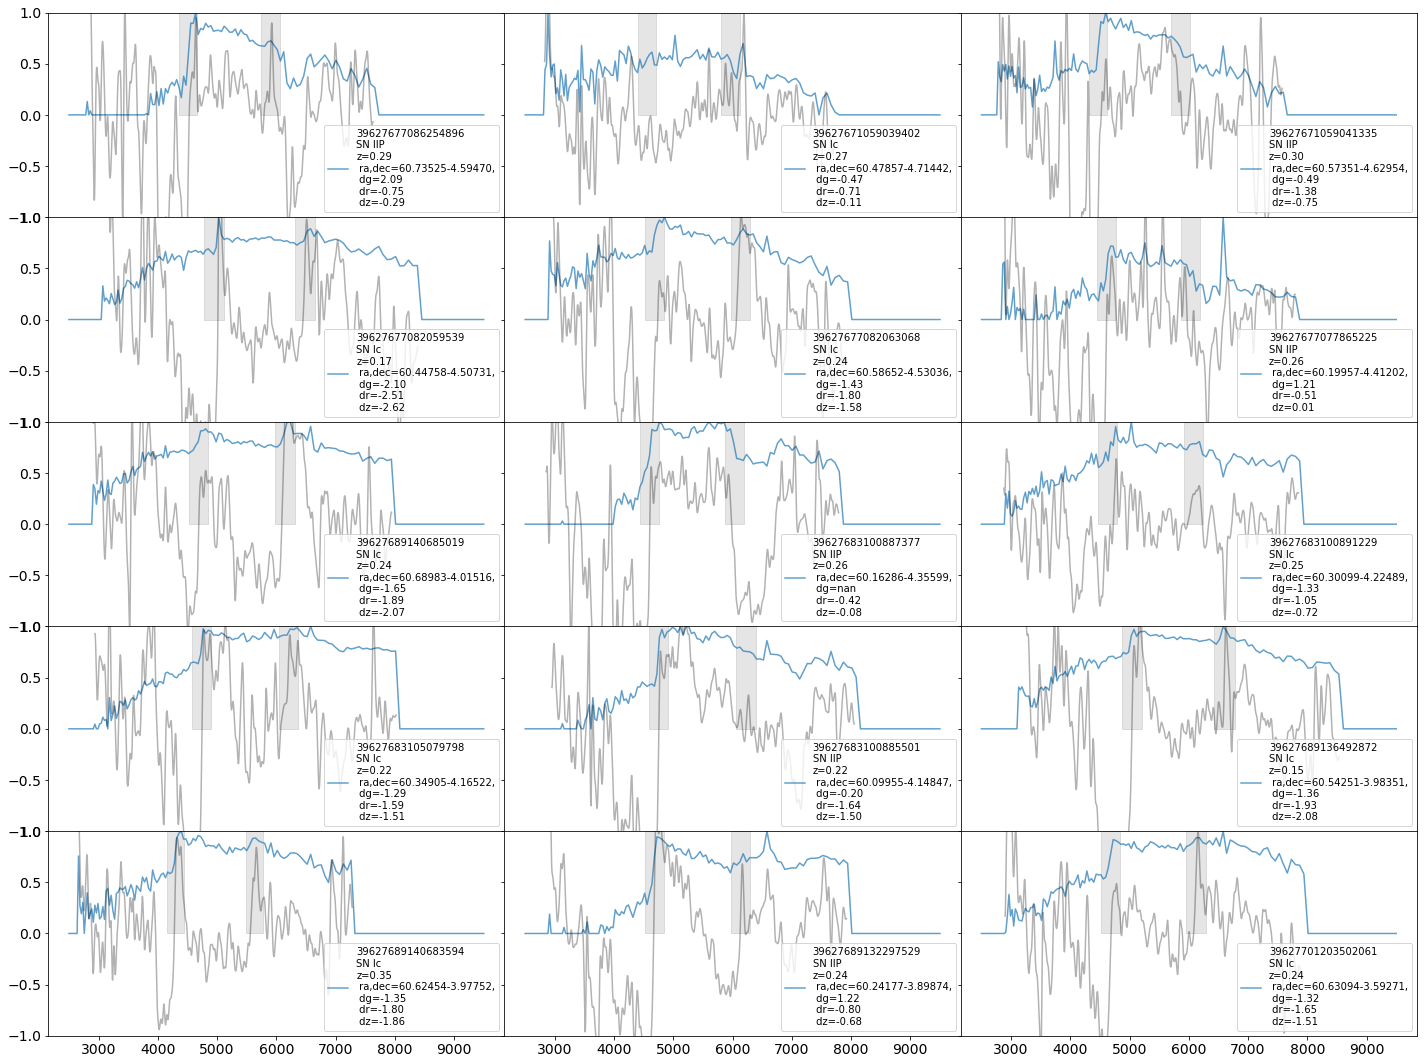

In [47]:
fig, axes = plt.subplots(5,3, figsize=(20,15), sharex=True, sharey=True,
                                             gridspec_kw={'wspace':0, 'hspace':0})
plt.ylim(-1,1)

#these lines are to add to the output plot the wavelengths between the arms
br_band=[5600,6000]
rz_band=[7400,7800]

allfmap=spectra.fibermap
allwave=spectra.wave['brz']
allflux=spectra.flux['brz']
allivar=spectra.ivar['brz']
allzbest=allfmap

rewave, reflux, reivar = rebin_flux(allwave, allflux, allivar, allfmap['Z'],
                                                    minwave=2500., maxwave=9500., nbins=150,
                                                    log=True, clip=True)
rsflux = rescale_flux(reflux)
R = Resolution(spectra.resolution_data['brz'][0])

for j, ax in zip(idx, axes.flatten()):

    delta_fibermag_g=allfmap['DELTAMAG_G'][j]
    delta_fibermag_r=allfmap['DELTAMAG_R'][j]
    delta_fibermag_z=allfmap['DELTAMAG_Z'][j]

    ax.plot(rewave, rsflux[j], alpha=0.7, label=str(allfmap['TARGETID'][j])+'\n'+allfmap[j]['CNNLABEL']+\
            '\nz={:.2f}'.format(allzbest[j]['Z'])\
            +'\n ra,dec={:.5f}{:.5f},'.format(allfmap[j]['TARGET_RA'],allfmap[j]['TARGET_DEC'])\
            +'\n dg={:.2f}'.format(delta_fibermag_g)\
            +'\n dr={:.2f}'.format(delta_fibermag_r)\
            +'\n dz={:.2f}'.format(delta_fibermag_z))


    this_br_band=br_band/(1.+(allzbest[j]['Z']))
    this_rz_band=rz_band/(1.+(allzbest[j]['Z']))  
    ax.fill_between(this_br_band,[0,0],[1,1],alpha=0.1,color='k')
    ax.fill_between(this_rz_band,[0,0],[1,1],alpha=0.1,color='k')                      
    ax.legend(fontsize=10, loc='lower right')

    spectype = allzbest['SPECTYPE'][j].strip()
    subtype = allzbest['SUBTYPE'][j].strip()
    fulltype = (spectype, subtype)
    ncoeff = templates[fulltype].flux.shape[0]
    coeff = allzbest['COEFF'][j][0:ncoeff]
    tflux = templates[fulltype].flux.T.dot(coeff)
    twave = templates[fulltype].wave * (1+allzbest[j]['Z'])
    txflux = R.dot(resample_flux(spectra.wave['brz'], twave, tflux))
    res=allflux[j]-txflux
    res_smooth = gaussian_filter1d(res, 25)
    ax.plot(allwave/(1.+(allzbest[j]['Z'])), res_smooth, 'k-', alpha=0.3)

fig.tight_layout()
outplot = 'transient_candidates_icecube90.png'
fig.savefig(outplot, dpi=200)

In [48]:
write_spectra('cand_IceCube.fits', spectra[idx])

INFO:spectra.py:177:write_spectra: iotime 0.101 sec to write cand_IceCube.fits at 2021-09-24T22:40:24.517716


'/global/u2/p/palmese/desi/timedomain/nutarget/cand_IceCube.fits'

### Plot Spectra


In [49]:
import requests

def get_cutout(targetid, ra, dec, verbose=False):
    """Grab and cache legacy survey cutouts.
    
    Parameters
    ----------
    targetid : int
        DESI target ID.
    ra : float
        Right ascension (degrees).
    dec : float
        Declination (degrees).
    verbose : bool
        Add some status messages if true.
        
    Returns
    -------
    img_name : str
        Name of JPG cutout file written after query.
    """
    img_name = '{}.jpg'.format(targetid)
    
    if os.path.exists(img_name):
        if verbose:
            print('{} exists.'.format(img_name))
    else:
        if verbose:
            print('Accessing {}'.format(img_name))
        img_url = 'https://www.legacysurvey.org/viewer/cutout.jpg?ra={}&dec={}&%22/pix=0.25&layer=dr8&size=180'.format(ra, dec)
        with open(img_name, 'wb') as handle: 
            response = requests.get(img_url, stream=True) 
            if not response.ok: 
                print(response) 
            for block in response.iter_content(1024): 
                if not block: 
                    break 
                handle.write(block)
    
    return img_name

In [52]:
from scipy.ndimage import gaussian_filter1d
from astropy.io import ascii, fits

mpl.rc('figure', max_open_warning = 0)
# Emission and absorption lines from Prospect tables.
emi_lines = ascii.read('../db/emission_lines.txt', comment='#', names=['name','longname','lambda','vacuum','major'])
abs_lines = ascii.read('../db/absorption_lines.txt', comment='#', names=['name','longname','lambda','vacuum','major'])

emi_lines_major = emi_lines[emi_lines['major']=='True']
abs_lines_major = abs_lines[abs_lines['major']=='True']


In [67]:
candspectra=spectra[idx]

3778.7509781569242 0
571.6084545850754 0
549.9253601618111 0
201.51536017656326 0
177.3394799232483 0
670.4532096385956 0
1505.540117546916 0
919.2041358947754 0
82.96117636933923 0
915.2592389583588 0
650.5014274716377 0
117.17550134658813 0
72.19265282154083 0
2614.119541168213 0
612.560552418232 0


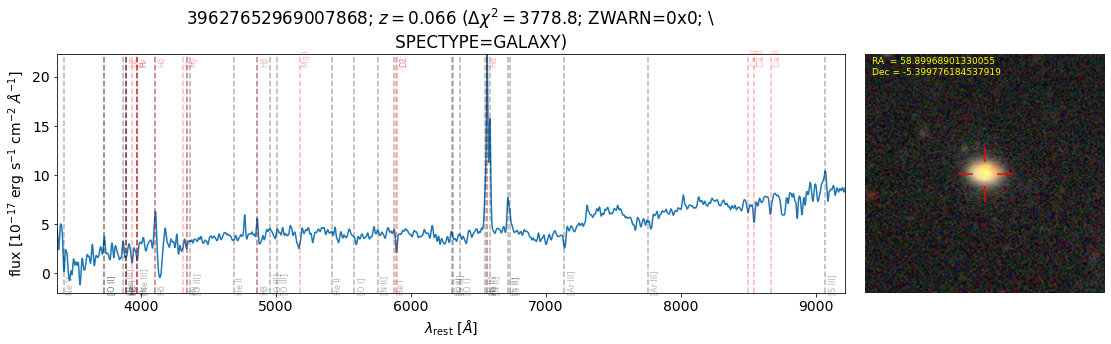

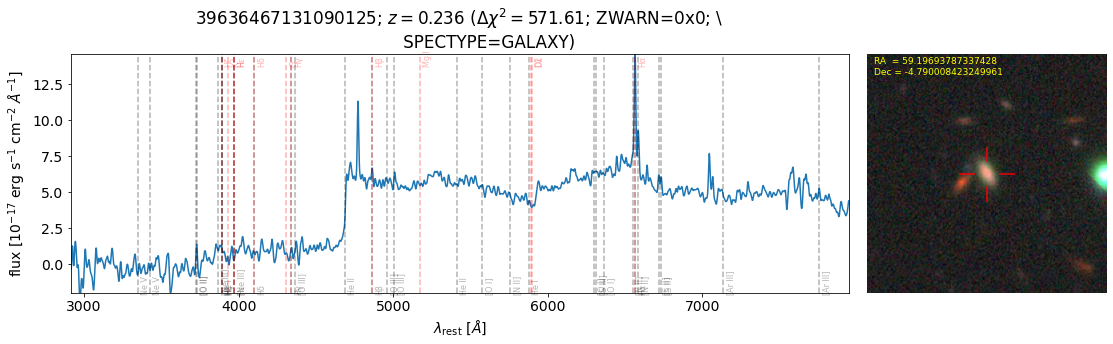

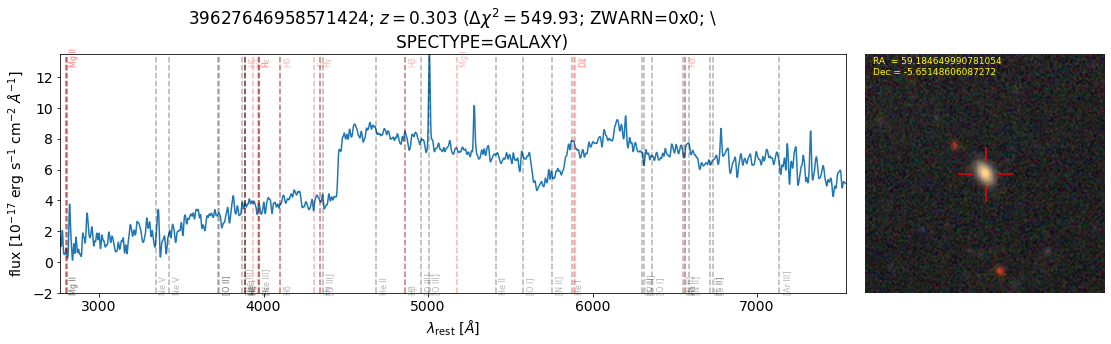

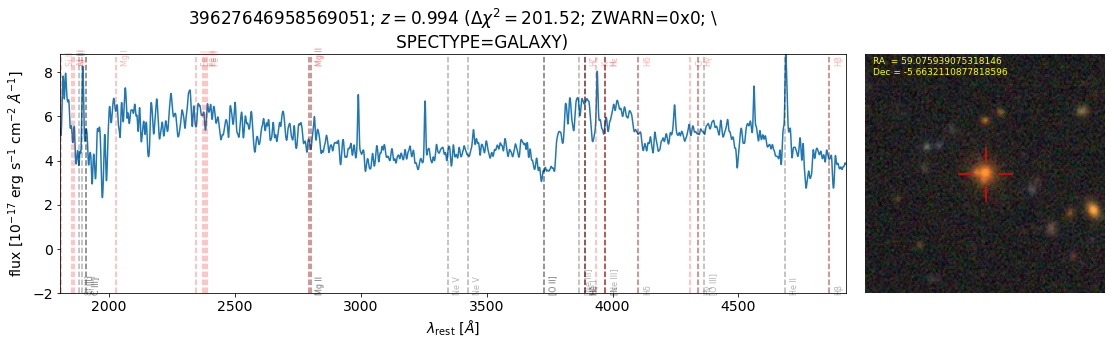

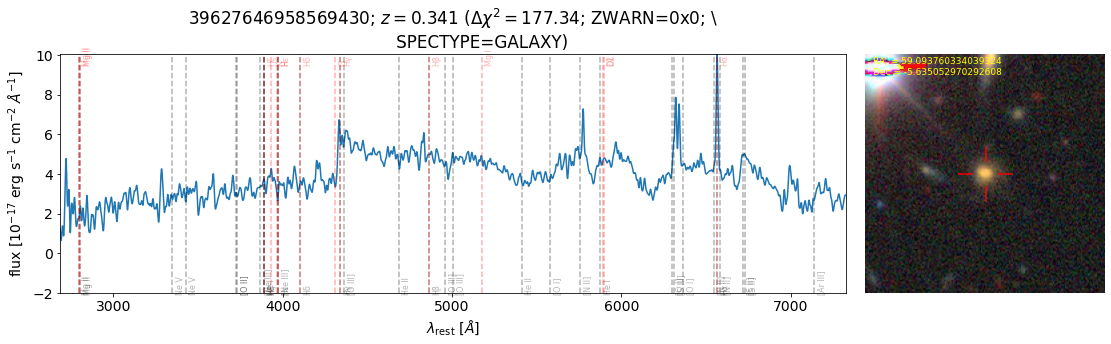

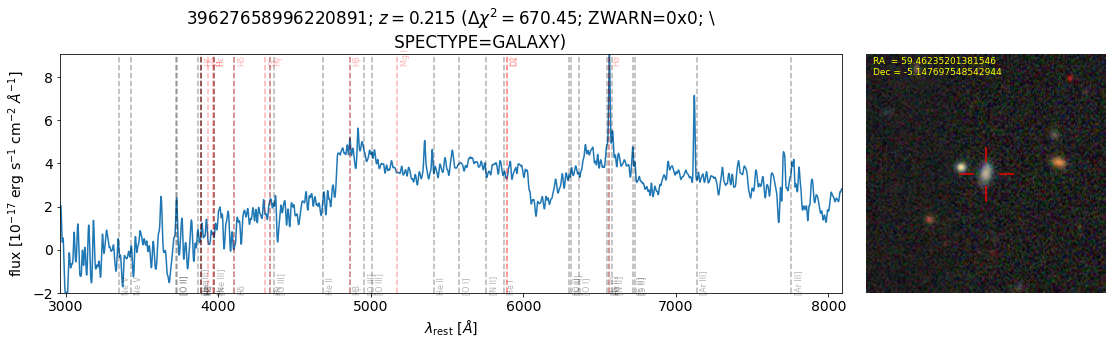

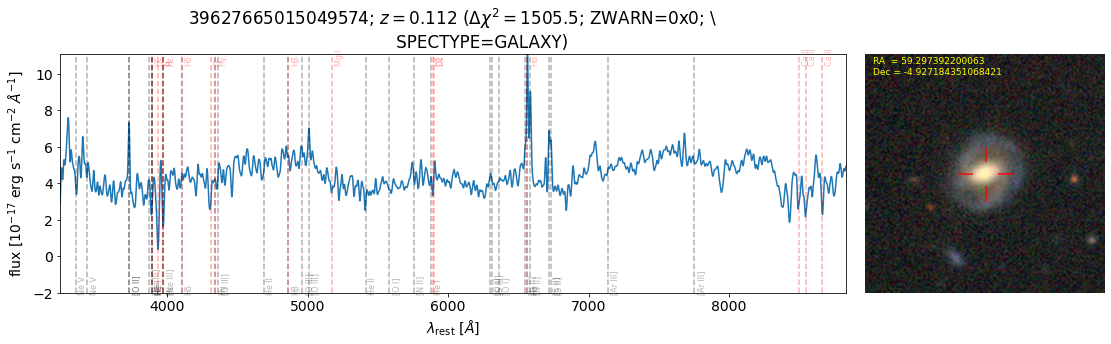

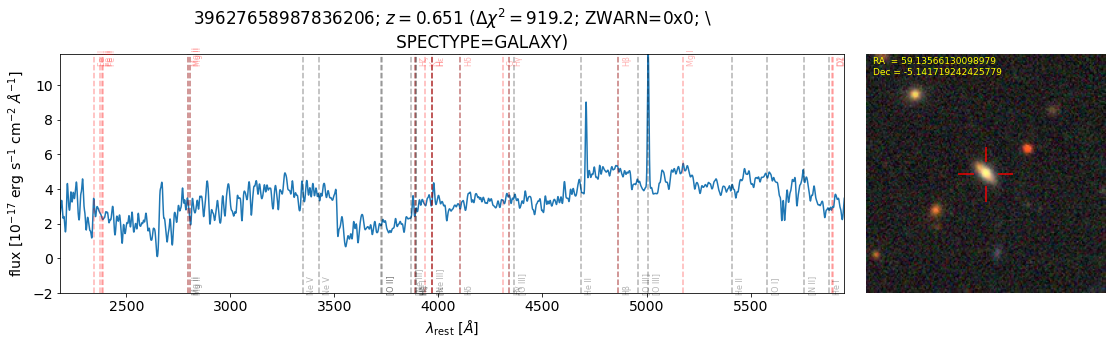

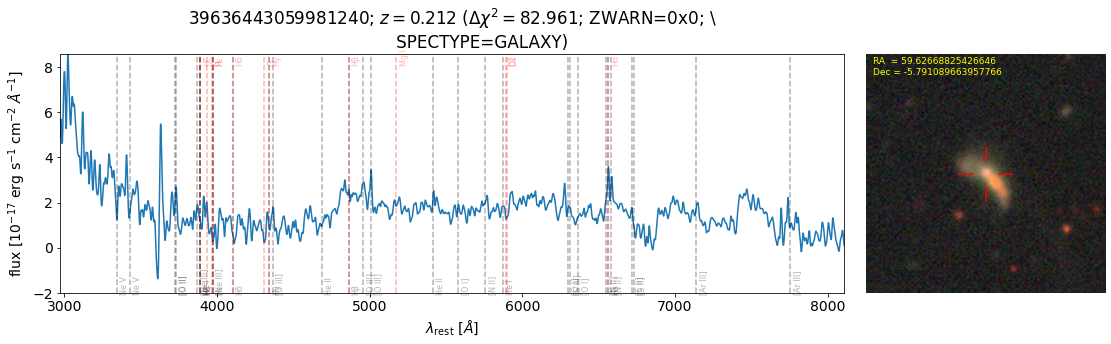

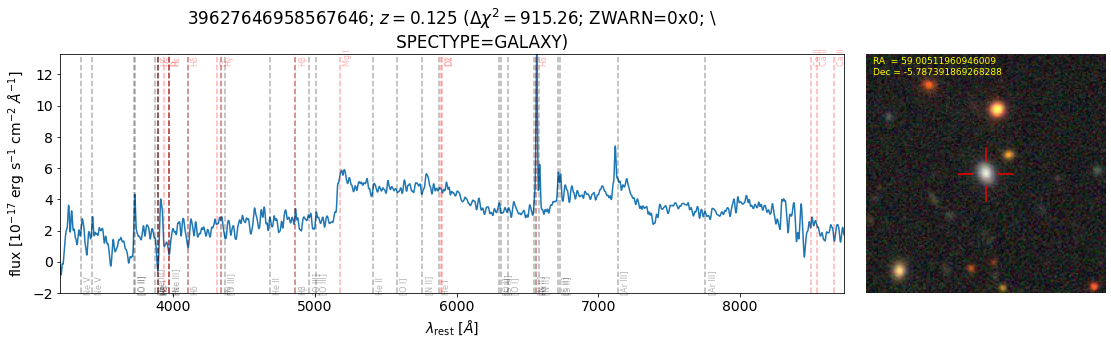

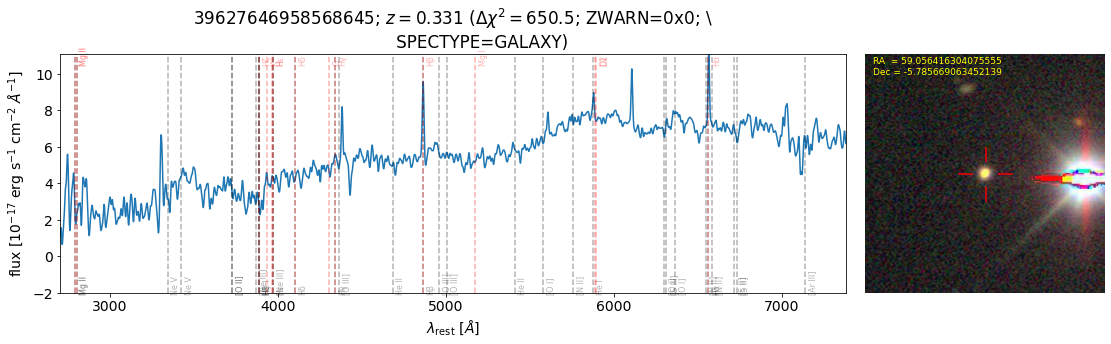

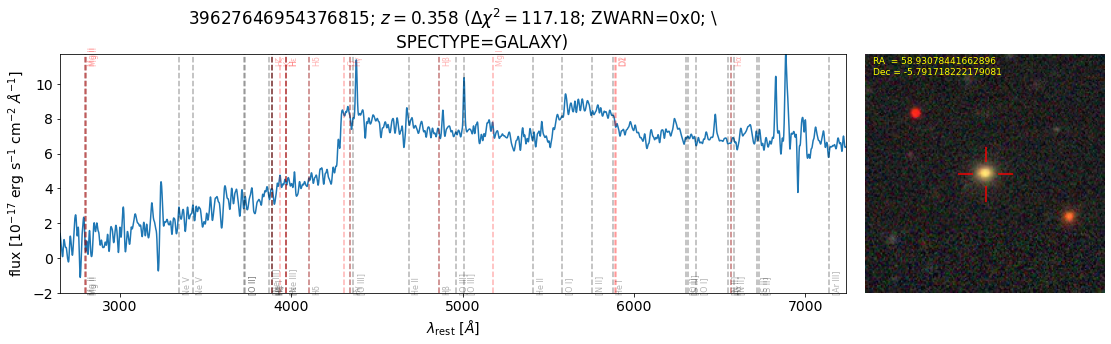

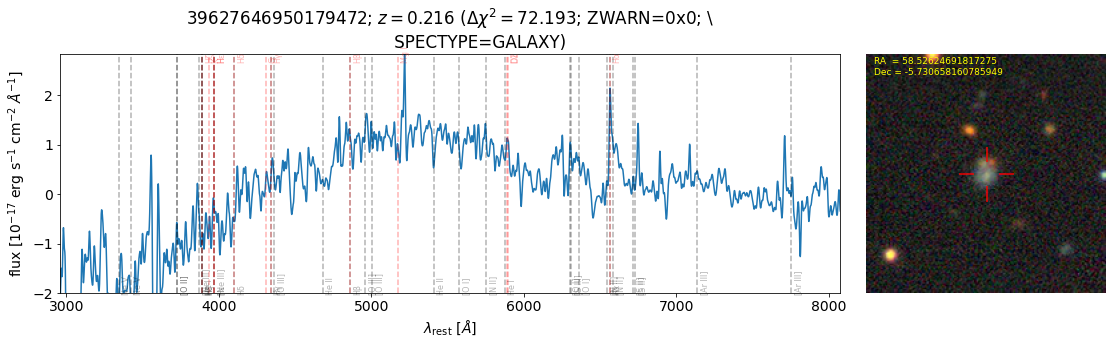

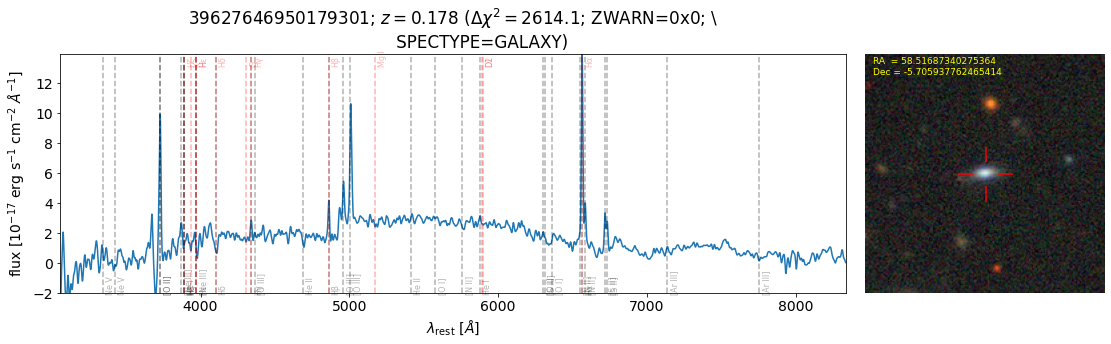

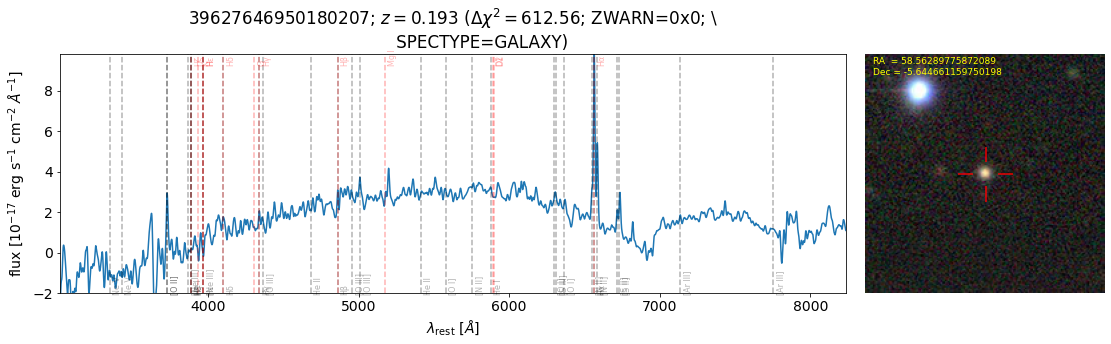

In [70]:
for i in range(candspectra.num_spectra()):
    
    fig, axes = plt.subplots(1,2, figsize=(16,5), gridspec_kw={'width_ratios':[3,1.1]},
                             tight_layout=True)
    
    # Plot the spectra.
    ax = axes[0]
    
    fmin, fmax = 1e99, -1e99

    coadded_flux = spectra[i]
    
    zbest = spectra.fibermap[i]
    z = zbest['Z']
    dchi2 = zbest['DELTACHI2']
    zwarn = zbest['ZWARN']
    sptype = zbest['SPECTYPE']
    print(dchi2, zwarn)

    smoothed = gaussian_filter1d(coadded_flux.flux['brz'][0], 7)
#     fmin = np.minimum(fmin, np.min(smoothed))
    fmax = np.maximum(fmax, np.max(smoothed))
#     print(fmin, fmax)
    fmin=-2
    restwave = coadded_flux.wave['brz']/(1+z)
    ax.plot(restwave, smoothed)
    
    for eline in emi_lines:
        wl = eline['lambda']#*(1 + z)
        if wl > restwave[0] and wl < restwave[-1]:
            ax.axvline(wl, ls='--', color='k', alpha=0.3)
            ax.text(wl+20, fmin, eline['name'], fontsize=8, rotation=90, alpha=0.3)

    for aline in abs_lines:
        wl = aline['lambda']#*(1 + z)
        if wl > restwave[0] and wl < restwave[-1]:
            ax.axvline(wl, ls='--', color='r', alpha=0.3)
            ax.text(wl+20, 0.95*fmax, aline['name'], color='r', fontsize=8, rotation=90, alpha=0.3)

    ax.set(xlabel=r'$\lambda_{\mathrm{rest}}$ [$\AA$]',
           xlim=(restwave[0], restwave[-1]),
           ylabel=r'flux [$10^{-17}$ erg s$^{-1}$ cm$^{-2}$ $\AA^{-1}$]',
           ylim=(fmin, fmax),
           title=r'{}; $z={:.3f}$ ($\Delta\chi^2={:.5g}$; ZWARN=0x{:x}; \
           SPECTYPE={:s})'.format(spectra.fibermap[i]['TARGETID'], z, dchi2, zwarn, sptype),
          )
    
    # Plot the image cutout.
    ax = axes[1]
    
    obj = spectra.fibermap[i]
    img_file = get_cutout(obj['TARGETID'], obj['TARGET_RA'], obj['TARGET_DEC'])
    img = mpl.image.imread(img_file)

    ax.imshow(img)

    x1, x2, x3, x4 = [90, 90], [70, 80], [90, 90], [100,110]
    y1, y2, y3, y4 = [70, 80], [90, 90], [100,110], [90,90]
    ax.plot(x1, y1, x2, y2, x3, y3, x4, y4, color='r', linewidth=2, alpha=0.7)
    ax.text(5,15, '{:3s} = {}\n{:3s} = {}'.format('RA', obj['TARGET_RA'], 'Dec', obj['TARGET_DEC']), color='yellow', fontsize=9)
    ax.set(aspect='equal')
           #title='{}, Tile {}, Exp {}'.format(obj['TILEID']))
    ax.axis('off')
    
    fig.savefig('spectra/spec_cutout_IceCube_{:06d}.png'.format(obj['TARGETID']), dpi=100)
    
#     # Clean up
#     fig.clear()
#     plt.close(fig)

### Check ALL spectra in the IceCube region

In [15]:
redux = '/global/cfs/cdirs/desi/users/sjbailey/spectro/redux/icecube-202109a/tiles/pernight/'
tile_number = '23005'
obsdate = '20210923'

prefix_in = '/'.join([redux,tile_number, obsdate])
fiberstatus_key = 'COADD_FIBERSTATUS'
ztable = 'redshifts'

# Access the zbest and coadd files.
# Files are organized by petal number.
zbfiles = sorted(glob('{}/redrock*.fits'.format(prefix_in)))
cafiles = sorted(glob('{}/spectra*.fits'.format(prefix_in)))


def get_petal_id(filename):
        return int(filename.split('/')[-1].split('-')[1])

def match_files(cafiles, zbfiles):  
    matched = [] 
    for _l1 in cafiles: 
        p1 = get_petal_id(_l1)  
        for _l2 in zbfiles: 
            p2 = get_petal_id(_l2) 
            if p1 == p2: 
                matched.append([_l1, _l2]) 
                break
    return matched 

# Loop through zbest and coadd files for each petal.
# Extract the fibermaps, ZBEST tables, and spectra.
# Keep only BGS targets passing basic event selection.
allzbest = None
allfmap = None
allwave = None
allflux = None
allivar = None
allmask = None
allres  = None

print('Tile: {} - {}'.format(tile_number, obsdate))

for cafile, zbfile in match_files(cafiles, zbfiles):
    print('  - Petal {}'.format(get_petal_id(cafile)))

    # Access data per petal.
    zbest = Table.read(zbfile, ztable)
    pspectra = read_spectra(cafile)
    select_nite = pspectra.fibermap['NIGHT'] == int(obsdate)
    pspectra = pspectra[select_nite]

    #It would require to only select a single night first though.
    cspectra = coadd_cameras(pspectra)
    fibermap = cspectra.fibermap

    # Apply standard event selection.
    isTGT = fibermap['OBJTYPE'] == 'TGT'
    isGAL = zbest['SPECTYPE'] == 'GALAXY'

    #This is old selection, does not work anymore! BGS target is always 0
    #isBGS = bgs_mask.mask(bgs_bits) != 0                    
    isGoodFiber = fibermap[fiberstatus_key] == 0                    
    isGoodZbest = (zbest['DELTACHI2'] > 25.) & (zbest['ZWARN'] == 0)
    select = isTGT & isGAL & isGoodFiber # & isBGS & isGoodZbest

    fibermap = delta_mag(cspectra, fibermap, select, nsigma=3)

    print('     + selected: {}'.format(np.sum(select)))

    # Accumulate spectrum data.
    if (np.sum(select) > 0):
        if allzbest is None:
            allzbest = zbest[select]
            allfmap = fibermap[select]
            allwave = cspectra.wave['brz']
            allflux = cspectra.flux['brz'][select]
            allivar = cspectra.ivar['brz'][select]
            allmask = cspectra.mask['brz'][select]
            allres  = cspectra.resolution_data['brz'][select]
        else:
            allzbest = vstack([allzbest, zbest[select]])
            allfmap = vstack([allfmap, fibermap[select]])
            allflux = np.vstack([allflux, cspectra.flux['brz'][select]])
            allivar = np.vstack([allivar, cspectra.ivar['brz'][select]])
            allmask = np.vstack([allmask, cspectra.mask['brz'][select]])
            allres  = np.vstack([allres, cspectra.resolution_data['brz'][select]])


Tile: 23005 - 20210923
  - Petal 0
INFO:spectra.py:282:read_spectra: iotime 1.557 sec to read spectra-0-23005-20210923.fits at 2021-09-28T09:50:48.533543


/global/homes/p/palmese/desi/timedomain/desitrip/py/desitrip/deltamag.py:44: RuntimeWarning: divide by zero encountered in log10
  fibermag = 22.5 - 2.5*np.log10(fiberflux)
/global/common/software/desi/cori/desiconda/20200801-1.4.0-spec/code/speclite/0.13/speclite/filters.py:1118: RuntimeWarning: invalid value encountered in log10
  return -2.5 * np.log10(maggies)


     + selected: 333
  - Petal 1
INFO:spectra.py:282:read_spectra: iotime 1.697 sec to read spectra-1-23005-20210923.fits at 2021-09-28T09:51:00.690286
     + selected: 293
  - Petal 2
INFO:spectra.py:282:read_spectra: iotime 1.688 sec to read spectra-2-23005-20210923.fits at 2021-09-28T09:51:14.161456
     + selected: 346
  - Petal 3
INFO:spectra.py:282:read_spectra: iotime 1.604 sec to read spectra-3-23005-20210923.fits at 2021-09-28T09:51:26.778473
     + selected: 303
  - Petal 4
INFO:spectra.py:282:read_spectra: iotime 1.678 sec to read spectra-4-23005-20210923.fits at 2021-09-28T09:51:39.200091
     + selected: 332
  - Petal 5
INFO:spectra.py:282:read_spectra: iotime 1.540 sec to read spectra-5-23005-20210923.fits at 2021-09-28T09:51:51.454731
     + selected: 340
  - Petal 6
INFO:spectra.py:282:read_spectra: iotime 1.730 sec to read spectra-6-23005-20210923.fits at 2021-09-28T09:52:05.537595
     + selected: 322
  - Petal 7
INFO:spectra.py:282:read_spectra: iotime 1.679 sec to r

In [18]:
gal_spectra = Spectra(bands=['brz'],
                       wave={'brz' : allwave},
                       flux={'brz' : allflux},
                       ivar={'brz' : allivar},
                       mask={'brz' : allmask},
                       resolution_data={'brz' : allres},
                       fibermap=allfmap
                   )

In [19]:
ra_gal,dec_gal=gal_spectra.fibermap['TARGET_RA'], gal_spectra.fibermap['TARGET_DEC']
hpixs_gal=[]
for k in range(ra_gal.shape[0]):
    hpixs_gal.append(hp.ang2pix(nside,ra_gal[k],dec_gal[k],nest=True, lonlat=True))
    
hpixs_gal=np.array(hpixs_gal)

idx_gal=[]
for pix90 in pixs90:
    thisidx = np.where(hpixs_gal==pix90)
    if thisidx[0].shape[0]>0:
        idx_gal.append(thisidx[0][0])

In [20]:
ra_gal[idx_gal].shape

(152,)